# Определение стоимости автомобилей

<h1>План работы<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import time

Сохраним датасет в переменной `data`

In [2]:
data = pd.read_csv('/datasets/autos.csv', parse_dates = [0, 12])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Проверим, нет ли в базе данных объявлений моложе даты самой выгруки

In [4]:
data.query('DateCreated	 > DateCrawled')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


Признаки `DateCrawled` — дата скачивания анкеты из базы, `DateCreated` — дата создания анкеты, NumberOfPictures — количество фотографий автомобиля, `PostalCode` — почтовый индекс владельца анкеты (пользователя), `LastSeen` — дата последней активности пользователя, `RegistrationMonth` - месяц регистрации не оказывают влияние на рыночную стоимость автомобиля. Удалим их перед началом анализа

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Приведем все столбцы к стандартному виду

In [7]:
data = data.rename(columns = {
                   'VehicleType': 'vehicle_type', 
    'RegistrationYear':'registration_year', 
    
    'FuelType':'fuel_type'})
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Проверим наличие явных дубликатов

In [8]:
data.duplicated().sum()

45040

In [9]:
data = data.drop_duplicates()

Изучим основную статистическую информацию в столбцах

In [10]:
data.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Мы видим, что некоторые данные нуждаются в обработке, в частности у нас есть 0 значения в столбцах цена и мощность, а так же выбросы в столбце год регистрации. Отредактируем эти данные**

***Цена***


Построим гистограмму

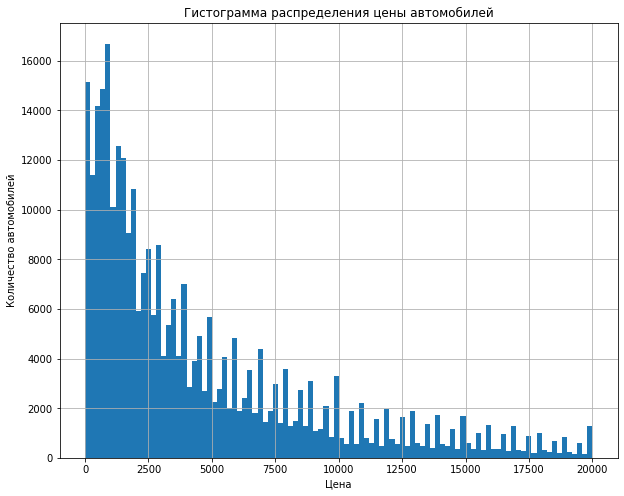

In [11]:
data['price'].hist(bins = 100, figsize=(10,8))
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.title('Гистограмма распределения цены автомобилей')
plt.show()

Построим диаграмму размаха

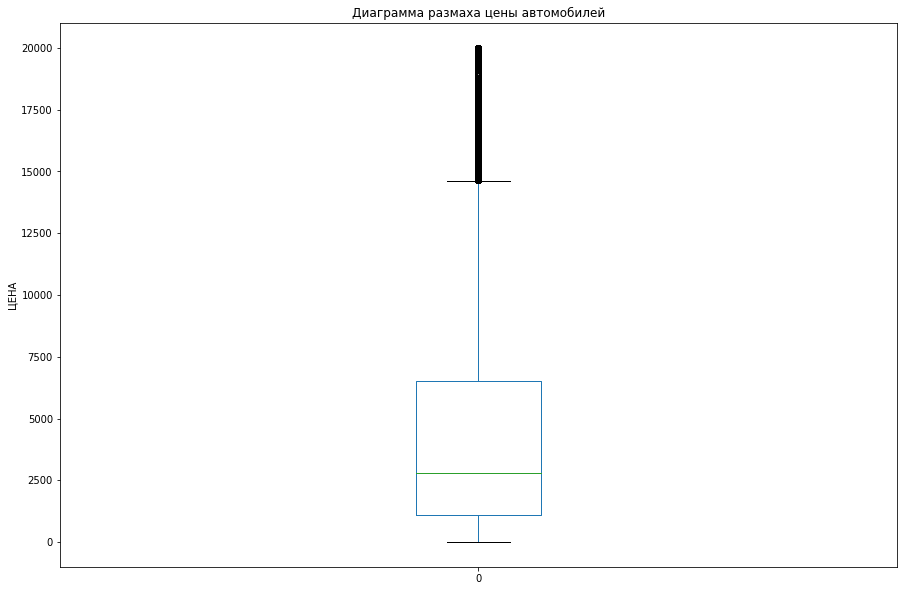

In [12]:
data['price'].plot(kind='box', figsize=(15, 10), use_index = None )

plt.ylabel('ЦЕНА')
plt.title('Диаграмма размаха цены автомобилей')
plt.show()

Мы видим, что у нас присутствуют 0 значения и выбросы в верхней части. Предлагаю взять в качестве цены значения 95% доверительного интервала

In [13]:
data['price'].quantile([0.025, 0.975])

0.025        0.0
0.975    16990.0
Name: price, dtype: float64

In [14]:
data = data.query('200 <= price <= 16950')
data.describe()

,price,registration_year,power,kilometer
count,286425.000000,286425.000000,286425.000000,286425.000000
mean,4341.296423,2003.918806,111.012366,128501.998778
std,4010.216105,69.103550,200.926002,37019.658458
min,200.000000,1000.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,70.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6350.000000,2008.000000,141.000000,150000.000000
max,16950.000000,9999.000000,20000.000000,150000.000000


***Год регистрации***

Построим диаграмму рассеивания

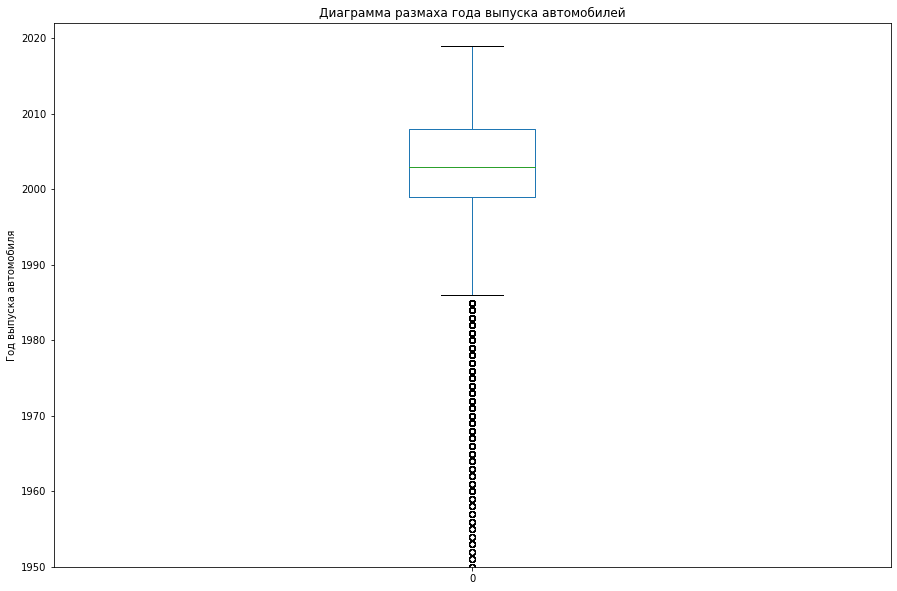

In [15]:
data['registration_year'].plot(kind='box', figsize=(15, 10), use_index = None)

plt.ylabel('Год выпуска автомобиля')
plt.title('Диаграмма размаха года выпуска автомобилей')
plt.ylim(1950, 2022)
plt.show()


count    286234.000000
mean       2003.204717
std           7.268420
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

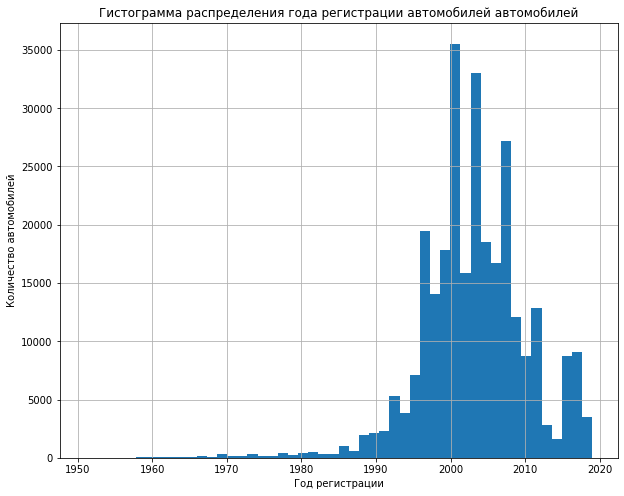

In [16]:
data = data.query('1950<registration_year <= 2022')
data['registration_year'].hist(figsize=(10,8), bins = 50)
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей')
plt.title('Гистограмма распределения года регистрации автомобилей автомобилей')
data['registration_year'].describe()

На диаграмме рассеивания мы видим выбросе после примерно 1985 года, уберем их и ограничим верхний порог 2016 годом - год выгрузки объявлений

In [17]:
data = data.query('1985 <= registration_year <= 2016')
data.describe()

,price,registration_year,power,kilometer
count,269434.000000,269434.000000,269434.000000,269434.000000
mean,4366.180467,2002.982853,112.572775,128865.083842
std,4026.079230,5.821136,196.662488,36509.997834
min,200.000000,1985.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,75.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2007.000000,143.000000,150000.000000
max,16950.000000,2016.000000,20000.000000,150000.000000


***Коробка передач***

Посмотрим какие значения есть в столбце `gearbox`

In [18]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Заменим все пустые значение на `manual`. Будем считать, что по умолчанию машины идут с механической коробкой передач

In [19]:
data['gearbox'].fillna('manual', inplace=True)

***Была машина в ремонте или нет***

In [20]:
data['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

В столбце В столбце `repaired` заменим пустые значения на `unknown`

In [21]:
data['repaired'].fillna('unknown', inplace=True)

Модель автомобиля

Заменим пропущенные значения на `unknown`

In [22]:
data['model'].fillna('unknown', inplace=True)

***Тип кузова***

In [23]:
data['vehicle_type'].isna().sum()

16227

In [24]:
data['vehicle_type'].value_counts()

sedan          72135
small          63143
wagon          52917
bus            24410
convertible    16282
coupe          12385
suv             9279
other           2656
Name: vehicle_type, dtype: int64

Заполним пропущенные значения параметром `unknow`

In [25]:
data['vehicle_type'].fillna('unknown', inplace=True)

***Тип топлива***

Здесь так же пропущенные значения заменим на `unknown`

In [26]:
data['fuel_type'].fillna('unknown', inplace=True)

***Мощность***


In [27]:
data['power'].describe()

count    269434.000000
mean        112.572775
std         196.662488
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

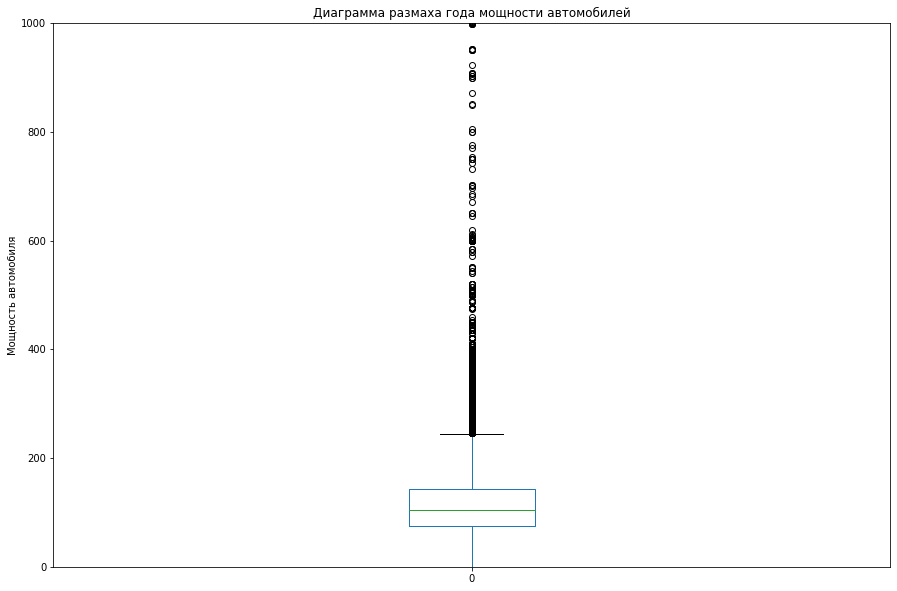

In [28]:
data['power'].plot(kind = 'box', figsize=(15, 10), use_index = None)
plt.ylabel('Мощность автомобиля')
plt.title('Диаграмма размаха года мощности автомобилей')
plt.ylim(0,1000)
plt.show()

Мы видим выбросы выше 250, удалим их, а так же удалим значения, равные меньшие 30 - исключим совсем старые автомобили с малой мощностью

In [29]:
data = data.query('30 < power <= 250')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237807 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              237807 non-null  int64 
 1   vehicle_type       237807 non-null  object
 2   registration_year  237807 non-null  int64 
 3   gearbox            237807 non-null  object
 4   power              237807 non-null  int64 
 5   model              237807 non-null  object
 6   kilometer          237807 non-null  int64 
 7   fuel_type          237807 non-null  object
 8   brand              237807 non-null  object
 9   repaired           237807 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.0+ MB


In [31]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Мы обработали данные, у нас осталось 247574 значения. Приступим к подготовки и обучению моделей

In [32]:
data = data.reset_index(drop=True)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


# Вывод

 - Были проанализированы данные
 
 - Названия столбцов приведены к классическому стилю

 - Обработаны пропуски,аномалии и некорректные значения

 - Убраны столбцы, которые не оказывают влияния на целевой признак
 


## Обучение моделей

**Создадим переменную `features` со всеми признаками, кроме `price`. Создадим переменную target с целевым признаком `price`**

In [33]:
features = data.drop(['price'], axis=1)
target = data['price']

Разобьем выборку на обучающую и тестовую

In [34]:
features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.25,
                                                                              random_state = 12345)
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178355 entries, 26464 to 217570
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       178355 non-null  object
 1   registration_year  178355 non-null  int64 
 2   gearbox            178355 non-null  object
 3   power              178355 non-null  int64 
 4   model              178355 non-null  object
 5   kilometer          178355 non-null  int64 
 6   fuel_type          178355 non-null  object
 7   brand              178355 non-null  object
 8   repaired           178355 non-null  object
dtypes: int64(3), object(6)
memory usage: 13.6+ MB


Сначала обучим модель с помощью `Catboost`, так как для нее не нужно кодирование категориальных признаков

In [35]:
%%time
сat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
train_dataset = Pool(features_train, target_train, cat_features=сat_features) 
test_dataset = Pool(features_test, target_test, cat_features=сat_features)
model_cat = CatBoostRegressor(random_state = 12345, verbose=False)
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.3, 0.4, 0.5],
        'depth': [2, 4, 6, 8]}
model_cat.grid_search(grid, train_dataset, cv=5, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1631.071134
bestIteration = 99

0:	loss: 1631.0711342	best: 1631.0711342 (0)	total: 4.33s	remaining: 2m 31s

bestTest = 1607.171034
bestIteration = 99

1:	loss: 1607.1710343	best: 1607.1710343 (1)	total: 7.76s	remaining: 2m 11s

bestTest = 1589.850836
bestIteration = 99

2:	loss: 1589.8508365	best: 1589.8508365 (2)	total: 11.1s	remaining: 2m 2s

bestTest = 1591.616449
bestIteration = 149

3:	loss: 1591.6164494	best: 1589.8508365 (2)	total: 16.1s	remaining: 2m 8s

bestTest = 1571.036059
bestIteration = 149

4:	loss: 1571.0360595	best: 1571.0360595 (4)	total: 21.1s	remaining: 2m 10s

bestTest = 1557.356492
bestIteration = 149

5:	loss: 1557.3564919	best: 1557.3564919 (5)	total: 26.3s	remaining: 2m 11s

bestTest = 1550.529308
bestIteration = 199

6:	loss: 1550.5293075	best: 1550.5293075 (6)	total: 37s	remaining: 2m 33s

bestTest = 1539.568942
bestIteration = 199

7:	loss: 1539.5689423	best: 1539.5689423 (7)	total: 47.4s	remaining: 2m 45s

bestTest = 1521.010437
bestIteration =

{'params': {'depth': 8, 'iterations': 200, 'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

*Выведем параметры лучшей модели и RMSE лучшей модели*

In [36]:
print('Параметры лучшей модели', model_cat.get_params())
print('RMSE:', model_cat.best_score_)

Параметры лучшей модели {'loss_function': 'RMSE', 'verbose': False, 'random_state': 12345, 'depth': 8, 'iterations': 200, 'learning_rate': 0.3}
RMSE: {'learn': {'RMSE': 1300.2273949450748}}


Выполним кросс-валидацию оптимальной модели

In [37]:
%%time
start = time.time()
model_cat_best = CatBoostRegressor(random_state=123,learning_rate=0.4, depth = 8, iterations=200, cat_features=сat_features)

model_cat_cross = cross_val_score(model_cat_best, features_train, target_train, scoring='neg_mean_squared_error')

end = time.time()
time_cat=round(end-start,2)


0:	learn: 2941.1541185	total: 331ms	remaining: 1m 5s
1:	learn: 2348.3682779	total: 578ms	remaining: 57.2s
2:	learn: 2027.1764124	total: 813ms	remaining: 53.4s
3:	learn: 1828.0961934	total: 1.09s	remaining: 53.6s
4:	learn: 1723.1597995	total: 1.35s	remaining: 52.5s
5:	learn: 1660.5712851	total: 1.56s	remaining: 50.5s
6:	learn: 1626.3682150	total: 1.79s	remaining: 49.4s
7:	learn: 1598.9960119	total: 2.08s	remaining: 49.9s
8:	learn: 1580.1173750	total: 2.22s	remaining: 47.1s
9:	learn: 1562.8534112	total: 2.45s	remaining: 46.6s
10:	learn: 1554.0010381	total: 2.62s	remaining: 45s
11:	learn: 1544.8145521	total: 2.82s	remaining: 44.2s
12:	learn: 1535.3340536	total: 2.98s	remaining: 42.9s
13:	learn: 1519.2990541	total: 3.13s	remaining: 41.5s
14:	learn: 1511.6322668	total: 3.32s	remaining: 41s
15:	learn: 1502.9715070	total: 3.5s	remaining: 40.3s
16:	learn: 1495.6776707	total: 3.74s	remaining: 40.2s
17:	learn: 1490.6485596	total: 3.94s	remaining: 39.8s
18:	learn: 1486.7207903	total: 4.21s	remain

In [38]:
#Рассчитаем rmse для модели
rmse_cat_best=((model_cat_cross*-1)**0.5).mean()

In [39]:
rmse_cat_best

1381.9165685891676

In [40]:
time_cat

242.46

Видим, что при большом количестве итераций модель начала "переобучаться" оптимальное значение iterations для данной модели 384

***Закодируем категориальные признаки методом `OheHotEncoder`***

Закодируем категориальные признаки методом OheHotEncoder и заново разобьем выборку на тренировочную и тестовую

In [41]:
col=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
features_ohe = pd.get_dummies(features[col], drop_first=True)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,target,test_size=0.25,
                                                                              random_state = 12345)
features_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178355 entries, 26464 to 217570
Columns: 303 entries, vehicle_type_convertible to repaired_yes
dtypes: uint8(303)
memory usage: 52.9 MB


***Линейная регрессия***

In [42]:
%%time
start = time.time()
# обучим модель на тренировочных данных и предскажем прогнозные значения
model_lr = LinearRegression(normalize=True)

rmse_lr = cross_val_score(model_lr, features_train_ohe, target_train_ohe, scoring = 'neg_mean_squared_error')


end = time.time()
time_lr=round(end-start,2)


CPU times: user 1min 32s, sys: 4min 12s, total: 5min 44s
Wall time: 5min 45s


In [43]:
rmse_lr_best=((rmse_lr*-1)**0.5).mean()
rmse_lr_best

499219416011898.3

***Случайный лес***

Для модели случайного леса закодируем категориальные признаки методом `OrdinalEncoder`

In [44]:
col=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
encoder = OrdinalEncoder()
encoder.fit(features_train[col])

cat_features = features_train[col]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
features_train_ord=features_train.copy()
for column in col:
    features_train_ord[column] = cat_features[column]

In [45]:
features_train_ord.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
26464,4.0,1999,1.0,75,116.0,150000,6.0,38.0,0.0
70024,5.0,2000,1.0,60,173.0,150000,6.0,38.0,0.0
101356,5.0,2001,1.0,50,143.0,150000,6.0,38.0,1.0
222691,8.0,2012,0.0,184,59.0,150000,6.0,20.0,0.0
152740,5.0,2006,1.0,70,55.0,150000,6.0,5.0,0.0


Обучим модель и подберем лучшие параметры

In [46]:
model_rf =  RandomForestRegressor(random_state=12345)
grid = {'n_estimators':[10,20,30,40,50],
        'max_depth': [5,6,7,8,9,10]}
rf = GridSearchCV(model_rf, grid, scoring='neg_mean_squared_error')
rf.fit(features_train_ord, target_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [10, 20, 30, 40, 50]},
             scoring='neg_mean_squared_error')

In [47]:
rf.best_params_

{'max_depth': 10, 'n_estimators': 50}

Проведем кросс-валидацию на лучших параметрах модели

In [48]:
start = time.time()
model_rf_best = RandomForestRegressor(random_state=123,n_estimators = 50 , max_depth = 10)

rf_cross = cross_val_score(model_rf_best, features_train_ord, target_train, scoring='neg_mean_squared_error')

end = time.time()
time_rf=round(end-start,2)

In [49]:
rmse_rf_best=((rf_cross*-1)**0.5).mean()
rmse_rf_best

1626.69037290162

In [50]:
time_rf

62.68

**Библиотека градиентного бустинга LightGBM**

In [51]:
# Удалим ненужные дата сеты, чтобы не нагружать память
del data
del features_train_ohe

Обучим модель и подберем оптимальные парматеры

In [52]:
%%time

for i in сat_features:
    features_train[i] = features_train[i].astype('category')


regressor = LGBMRegressor(n_estimators=1000) 
grid = {'num_leaves':[11, 50],
        'learning_rate': [0.3, 0.4]}
model_lgbm = GridSearchCV(regressor, grid, scoring='neg_mean_squared_error', verbose=10, cv=3)
model_lgbm.fit(features_train, target_train, categorical_feature=сat_features)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 1/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=25.4min
[CV 2/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 2/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=22.2min
[CV 3/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 3/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=26.3min
[CV 1/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 1/3; 2/4] END .........learning_rate=0.3, num_leaves=50; total time=126.8min
[CV 2/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 2/3; 2/4] END ..........learning_rate=0.3, num_leaves=50; total time=89.7min
[CV 3/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 3/3; 2/4] END .........learning_rate=0.3, num

GridSearchCV(cv=3, estimator=LGBMRegressor(n_estimators=1000),
             param_grid={'learning_rate': [0.3, 0.4], 'num_leaves': [11, 50]},
             scoring='neg_mean_squared_error', verbose=10)

In [53]:
# Выведем на экран лучшую модель
model_lgbm.best_params_

{'learning_rate': 0.3, 'num_leaves': 11}

Проведем кросс-валидацию луучшей модели

In [54]:
%%time
start = time.time()
model_lgbm_best =  LGBMRegressor(n_estimators=1000, num_leaves = 11, learning_rate = 0.3)

model_lgbm_cross = cross_val_score(model_lgbm_best, features_train, target_train, scoring='neg_mean_squared_error')

end = time.time()
time_lgbm=round(end-start,2)

CPU times: user 41min 50s, sys: 23.9 s, total: 42min 14s
Wall time: 42min 27s


In [55]:
rmse_lgbm_best=((model_lgbm_cross*-1)**0.5).mean()
rmse_lgbm_best

1363.2107665025187

In [56]:
time_lgbm

2547.55

Обучим модель на лучших параметрах и проверим на тестовой выборке

# Вывод:
    
    Мы сделали 2 выборки, обучающую и тестовую и построили 4 модели предсказания:
     - CatBoost (проверяли без кодирования категориальных признаков)
     - Линейная регрессия
     - модель "Случайного леса"
     - LightGBM
    Для каждой модели подсчитана метрика качества RMSE, а так же время обучения и предсказания модели
***Теперь мы можем приступить к анализу полученных результатов и выбору лучшей модели***

## Анализ моделей

Создадим таблицу с результатами работы наших моделей

In [68]:
columns=['RMSE модели', 'Скорость обучения-предсказания']
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBM']
data = [
    [rmse_lr_best, time_lr],
    [rmse_rf_best, time_rf],
    [round(rmse_cat_best, 2), time_cat],
    [round(rmse_lgbm_best,2), time_lgbm]
]

final_tabl = pd.DataFrame(data = data, columns = columns, index=index)

In [69]:
final_tabl

,RMSE модели,Скорость обучения-предсказания
LinearRegression,4.992194e+14,345.39
RandomForestRegressor,1.626690e+03,62.68
CatBoostRegressor,1.381920e+03,242.46
LightGBM,1.363210e+03,2547.55


Мы видим что модели CatBoostRegressor и LightGBM показали схожие результаты с небольшим преимуществом модели LightGBM, однако время обучения  модели CatBoostRegressor намного меньше, поэтому выбираем эту модель в качестве лучшей модели

***Проверим лучшую модель на тестовых данных***

Получим предсказания модели

In [71]:
model_cat_best.fit(features_train, target_traind)
predict = model_cat_best.predict(features_test)

0:	learn: 2978.9967355	total: 310ms	remaining: 1m 1s
1:	learn: 2346.1809817	total: 640ms	remaining: 1m 3s
2:	learn: 2021.7524444	total: 931ms	remaining: 1m 1s
3:	learn: 1843.4044258	total: 1.28s	remaining: 1m 2s
4:	learn: 1734.7385752	total: 1.61s	remaining: 1m 2s
5:	learn: 1663.0431398	total: 1.81s	remaining: 58.5s
6:	learn: 1627.5374661	total: 2.07s	remaining: 57s
7:	learn: 1602.8960079	total: 2.3s	remaining: 55.2s
8:	learn: 1584.2755639	total: 2.61s	remaining: 55.3s
9:	learn: 1569.4553653	total: 2.83s	remaining: 53.8s
10:	learn: 1558.3251661	total: 3.11s	remaining: 53.4s
11:	learn: 1543.2236327	total: 3.31s	remaining: 51.8s
12:	learn: 1535.0280487	total: 3.53s	remaining: 50.8s
13:	learn: 1518.2303170	total: 3.84s	remaining: 51s
14:	learn: 1509.4190046	total: 4.05s	remaining: 50s
15:	learn: 1501.0985429	total: 4.27s	remaining: 49.1s
16:	learn: 1494.6170759	total: 4.48s	remaining: 48.2s
17:	learn: 1489.0907261	total: 4.79s	remaining: 48.4s
18:	learn: 1482.1725622	total: 5.04s	remainin

In [72]:
cat_test_rmse = (mean_squared_error(target_test, predict))** 0.5 
cat_test_rmse

1377.105181112033

# Показатель RMSE на тестовой выборке для наилучшей модели `CatBoostRegressor` составил 1496,198 Евро

Проверим модель на адекватность сравнив ее с константной моделью, предсказывающей средние значения

In [73]:
dummy_regr = DummyRegressor(strategy ="mean")

In [74]:
dummy_regr.fit(features_train_ord, target_train)

DummyRegressor()

In [75]:
dummy_predict = dummy_regr.predict(features_test_ord)

In [76]:
dummy_test_rmse = (mean_squared_error(target_test, dummy_predict))** 0.5 
dummy_test_rmse

4001.165449785194

RMSE константной модели выше, чем RMSE модели `CatBoostRegressor`, значит наша модель прошла проверку на адекватность и может быть рекомендована к применению

# Вывод по итогам проекта:

В теекущем проекте мы построили модели, которые определяли рыночную стоимость автомобиля по имеющимся данным

Мы использовали следующие типы моделей:CatBoostRegressor, LightGBM, LinearRegression и RandomForestRegressor

Опираясь на критерии заказчика, а именно:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели

Мы рекомендуем компании "Не бит, не крашен" модель `CatBoostRegressor` в качестве модели, предсказывающе стоимость автомобиля
